In [1]:
import os
import pickle
import sys
from pathlib import Path

sys.path.append("..")

import numpy as np
import rasterio
import rasterio.mask
from shapely import geometry
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [9]:
path_to_target_data = os.path.join("..", "data", "target")
path_to_features = os.path.join("..", "data", "processed_files", "tifs")

future_data = os.path.join(path_to_features, "2040_2050")
path_to_npys_data = os.path.join("..", "data", "npys_data")

In [10]:
# Add rectangles
rectangles =[(45, 121, 42.5, 128),  # Format: [ul_corner_y, ul_corner_x, lr_corner_y, lr_corner_x]
                (60, 60, 55, 70),
                (58, 25, 52, 38)]
months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
regions = ["Northern China", "Sothern Ural", "Eastern Europe"]
models = ["CNRM", "CMCC", "MRI"]
colors = ["C0", "C1", "C2"]
ssps = ["ssp126", "ssp245", "ssp585"]


In [11]:
region_bounds = []
for rect in rectangles:
    # Define coordinate region_bounds
    left = rect[1]
    top = rect[0]
    right = rect[3]
    bottom = rect[2]

    # Create object holding all crop features
    p1 = geometry.Point(left, bottom)
    p2 = geometry.Point(left, top)
    p3 = geometry.Point(right, top)
    p4 = geometry.Point(right, bottom)

    pointList = [p1, p2, p3, p4]
    bound = geometry.Polygon([i for i in pointList])
    region_bounds.append(bound)

In [12]:
patch = {}
for model, color in zip (models+["CMIP average", "ERA5"], colors+["red", "black"]):
    patch[model] = mpatches.Patch(color=color, label=model)
    # patch2 = mpatches.Patch(color='blue', label='2nd plot')
    # patch3 = mpatches.Patch(color='green', label='3rd plot')

In [13]:
import matplotlib
from matplotlib.ticker import ScalarFormatter
font = {'weight' : 'bold',
        'size'   : 14}

matplotlib.rc('font', **font)

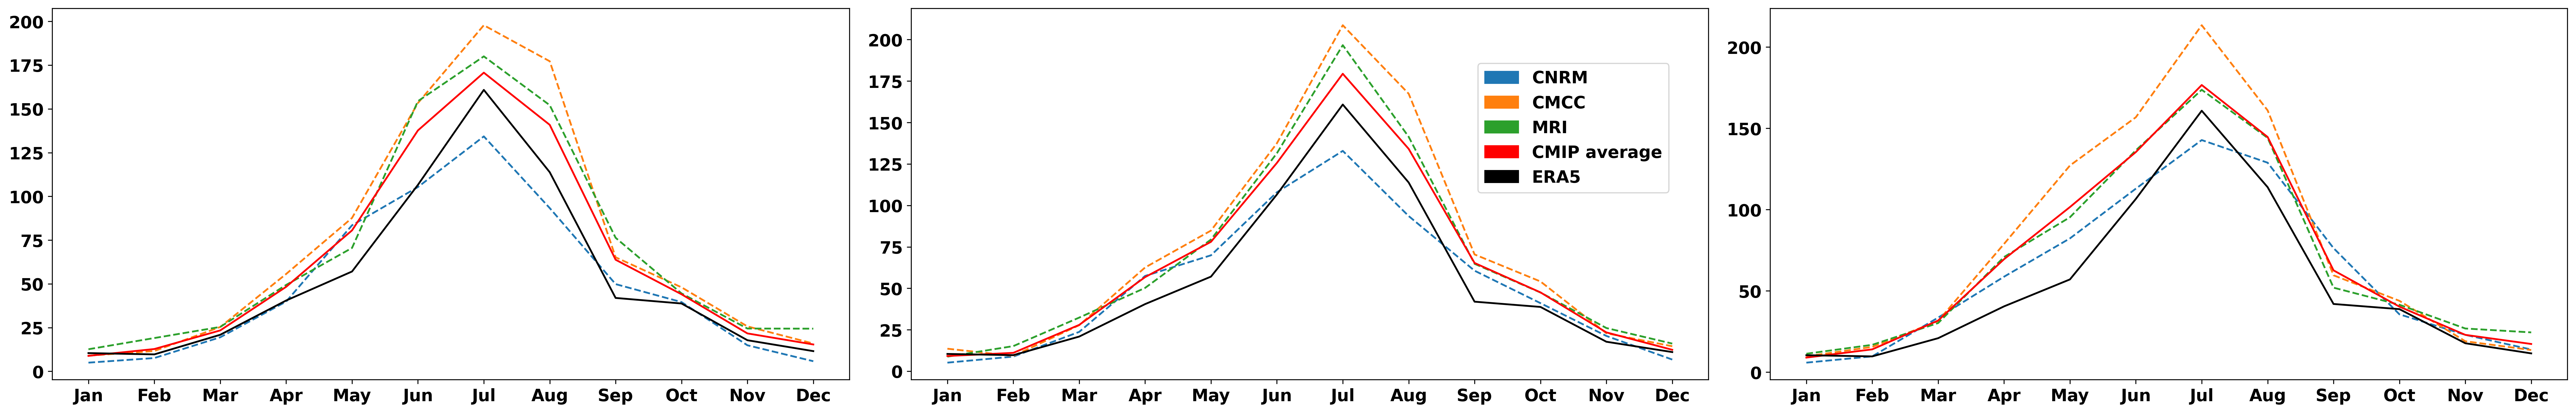

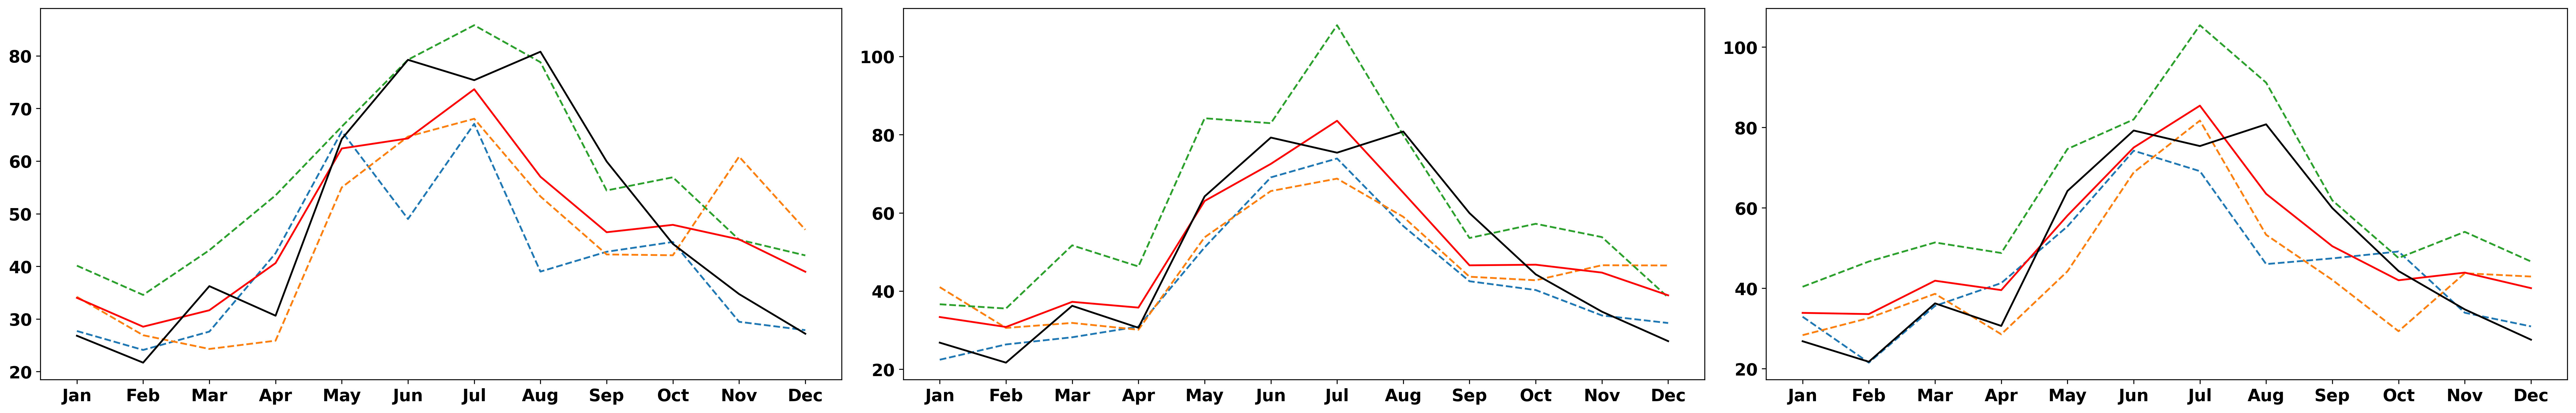

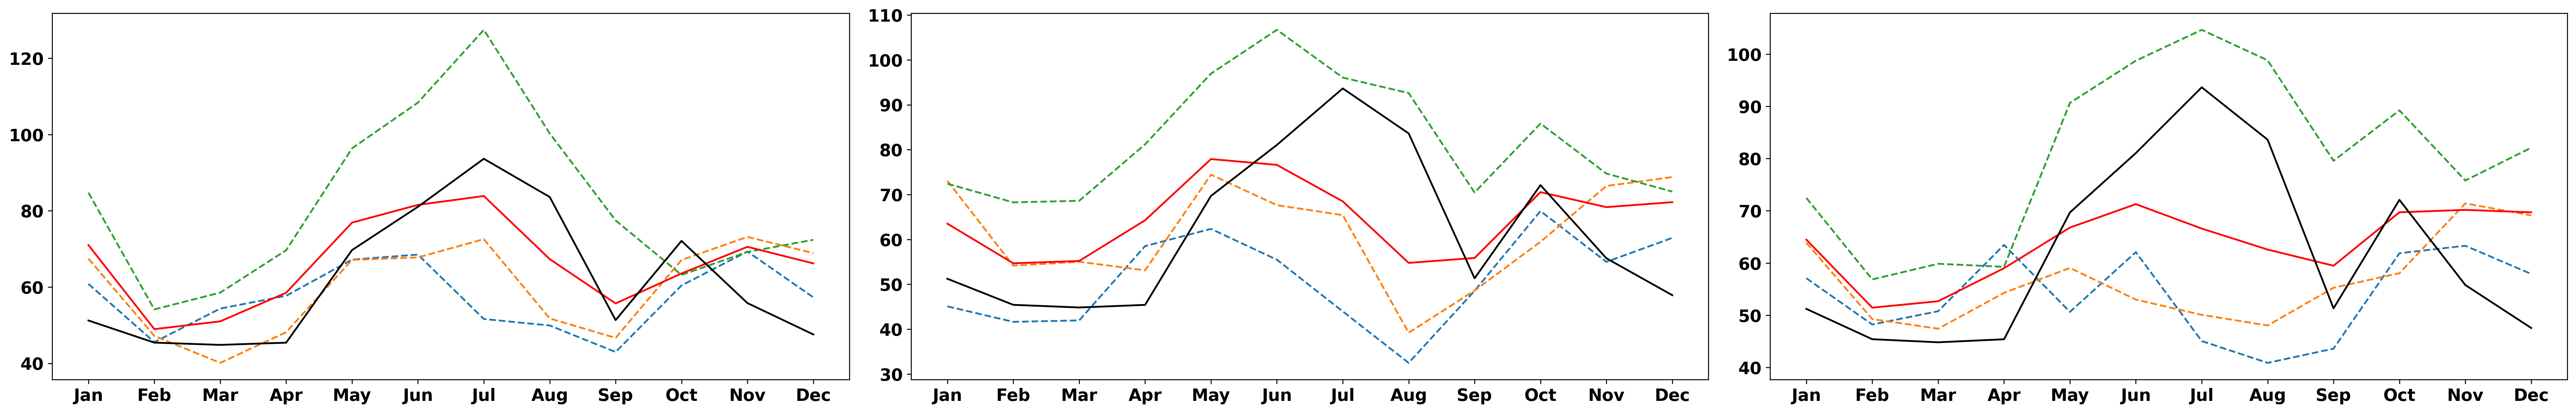

In [14]:
var = "tp"

for i, bound in enumerate(region_bounds):
    fig,ax = plt.subplots(nrows = 1, ncols = 3, figsize = (30,5))

    # Historical data within bounds
    file_hist = os.path.join(path_to_features, "2000_2010", "{}.tif".format(var))
    with rasterio.open(file_hist) as src:
                out_hist, out_transform = rasterio.mask.mask(src, [bound], crop=True)
    future_avg = np.mean(out_hist, axis = (1,2))

    # Loop over ssps
    for j, ssp in enumerate(ssps):
        diff_sum = np.zeros((12))
        for model, color in zip (models, colors):

            file_future = os.path.join(future_data, ssp, model, "{}.tif".format(var))
            with rasterio.open(file_future) as src:
                out_future, out_transform = rasterio.mask.mask(src, [bound], crop=True)
            
            # Optionally. Calculate difference with historical
            # data_diff = np.subtract(out_future, out_hist)
            # avg = np.mean(data_diff, axis = (1,2))

            # Calculate CMIP average
            avg = np.mean(out_future, axis = (1,2))

            diff_sum = diff_sum + avg
            ax[j].plot(months, avg, label = model, linestyle='dashed', color = color)

        # Plot average of CMIP models
        ax[j].plot(months, diff_sum/3, label = "average", linestyle='solid', color = "red")

        # Plot hitorical curve
        ax[j].plot(months, future_avg, label = "Era5", linestyle='solid', color = "black")

        # ax[j].set_title(ssp, fontsize = 16, weight = 'bold')
    lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
    lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
    if i==0:
        fig.legend(handles=[patch[models[0]],
                        patch[models[1]],
                        patch[models[2]],
                        patch["CMIP average"],
                        patch["ERA5"]],
                        bbox_to_anchor=(0.65, 0.85))
    # fig.suptitle(regions[i], fontsize = 16, weight = 'bold')
    plt.tight_layout()
    plt.gcf().set_dpi(300)
    plt.show()               